RL policy based on the [SoloParkour: Constrained Reinforcement Learning for Visual Locomotion from Privileged Experience](https://arxiv.org/abs/2409.13678). 

# Flat Ground

## Test In Simulation

In [ ]:
from Go2Py.robot.fsm import FSM
from Go2Py.robot.remote import KeyboardRemote, XBoxRemote
from Go2Py.robot.safety import SafetyHypervisor
from Go2Py.sim.mujoco import Go2Sim
from Go2Py.control.neuro_diff_sim import *
import torch

In [2]:
from Go2Py.robot.model import FrictionModel
friction_model = None
Fs = np.zeros(12)
mu_v = np.zeros(12)
#mu_v[[2,5,8,11]] = np.array([0.2167, -0.0647, -0.0420, -0.0834])
#Fs[[2,5,8,11]] = np.array([1.5259, 1.2380, 0.8917, 2.2461])

#mu_v[[0,3,6,9]] = np.array([0., 0., 0., 0.])
#Fs[[0,3,6,9]] = np.array([1.5, 1.5, 1.5, 1.5])
#mu_v[[2,5,8,11]] = np.array([0., 0., 0., 0.])
#Fs[[2,5,8,11]] = np.array([1.5, 1.5, 1.5, 1.5])

friction_model = FrictionModel(Fs=1.5, mu_v=0.3)
#friction_model = FrictionModel(Fs=0., mu_v=0.)
#friction_model = FrictionModel(Fs=Fs, mu_v=mu_v)
robot = Go2Sim(dt = 0.001, friction_model=friction_model)

In [3]:
remote = KeyboardRemote() # XBoxRemote() # KeyboardRemote()
robot.sitDownReset()
safety_hypervisor = SafetyHypervisor(robot)

In [4]:
def getRemote(remote):
    commands = remote.getCommands()
    commands[0] *= 0.6
    commands[1] *= 0.6
    zero_commands_xy = np.linalg.norm(commands[:2]) <= 0.2
    zero_commands_yaw = np.abs(commands[2]) <= 0.2
    if zero_commands_xy:
        commands[:2] = np.zeros_like(commands[:2])
    if zero_commands_yaw:
        commands[2] = 0
    return commands

In [5]:
class NeuroDiffSimController:
    def __init__(self, robot, remote, checkpoint):
        self.remote = remote
        self.robot = robot
        self.policy = Policy(checkpoint)
        self.command_profile = CommandInterface()
        self.agent = NeuroDiffSimAgent(self.command_profile, self.robot)
        self.hist_data = {}

    def init(self):
        self.obs = self.agent.reset()
        self.policy_info = {}
        self.command_profile.yaw_vel_cmd = 0.0
        self.command_profile.x_vel_cmd = 0.0
        self.command_profile.y_vel_cmd = 0.0

    def update(self, robot, remote):
        if not hasattr(self, "obs"):
            self.init()
        commands = getRemote(remote)
        self.command_profile.yaw_vel_cmd = -commands[2]
        self.command_profile.x_vel_cmd = commands[1]
        self.command_profile.y_vel_cmd = -commands[0]

        self.obs = self.agent.get_obs()
        action = self.policy(self.obs, self.policy_info)
        _, self.ret, self.done, self.info = self.agent.step(action)
        for key, value in self.info.items():
            if key in self.hist_data:
                self.hist_data[key].append(value)
            else:
                self.hist_data[key] = [value]

In [ ]:
robot.getJointStates()

In [ ]:
from Go2Py import ASSETS_PATH
import os
checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/neuro_diff_sim.pt')

controller = NeuroDiffSimController(robot, remote, checkpoint_path)
decimation = 20
fsm = FSM(robot, remote, safety_hypervisor, control_dT=decimation * robot.dt, user_controller_callback=controller.update)

# Slippage Analysis

In [8]:
contacts = []
feet_vels = []

while True:
    if remote.xbox_controller.digital_cmd[1]:
        break
    contact_state = robot.getFootContact()>15
    sites = ['FR_foot', 'FL_foot', 'RR_foot', 'RL_foot']
    feet_vel = [np.linalg.norm(robot.getFootVelInWorld(s)) for s in sites]
    contacts.append(contact_state)
    feet_vels.append(feet_vel)
    time.sleep(0.01)

feet_vels = np.stack(feet_vels)
contacts = np.stack(contacts)

In [ ]:
import matplotlib.pyplot as plt
start = 300
end = 1200
plt.plot(contacts[start:end,0])
plt.plot(feet_vels[start:end,0])
plt.legend(['contact state', 'foot velocity'])
plt.grid(True)
plt.tight_layout()
plt.savefig('foot_slipping_fric0.2.png')

**To Do**
- Train a policy without any actuator friction and check the plots for friction 0.2 and 0.6 
- Do the same experiment for the walk-these-ways policy
- While testing the walk these ways, check the output of the adaptation module for various friction numbers, any correlation?

In [8]:
fsm.close()

## Foot Contanct Analysis

In [ ]:
np.array(controller.hist_data["body_pos"])[0, 0, -1]

In [ ]:
plt.plot(np.array(controller.hist_data["body_pos"])[:, 0, -1])

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'controller.hist_data["torques"]' is a dictionary with torque profiles
torques = np.array(controller.hist_data["body_linear_vel"])[:, 0, :, 0]

# Number of torque profiles
torque_nb = torques.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(torque_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot each torque profile
for i in range(torque_nb):
    axes[i].plot(np.arange(torques.shape[0]) * robot.dt * decimation, torques[:, i])
    axes[i].set_title(f'Torque {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Torque Value')
    axes[i].grid(True)

# Remove any empty subplots if torque_nb is not a multiple of 3
for j in range(torque_nb, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("torque_profile.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'controller.hist_data["torques"]' is a dictionary with torque profiles
torques = np.array(controller.hist_data["torques"])

# Number of torque profiles
torque_nb = torques.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(torque_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot each torque profile
for i in range(torque_nb):
    axes[i].plot(np.arange(torques.shape[0]) * robot.dt * decimation, torques[:, i])
    axes[i].set_title(f'Torque {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Torque Value')
    axes[i].grid(True)

# Remove any empty subplots if torque_nb is not a multiple of 3
for j in range(torque_nb, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("torque_profile.png")
plt.show()

In [ ]:
# Extract the joint position data for the first joint over time
joint_pos = np.array(controller.hist_data["joint_vel"])[:, 0]

# Number of data points in joint_pos
n_data_points = len(joint_pos)

# Since you're plotting only one joint, no need for multiple subplots in this case.
# But to follow the grid requirement, we'll replicate the data across multiple subplots.
# For example, let's assume you want to visualize this data 9 times in a 3x3 grid.

n_cols = 3
n_rows = int(np.ceil(torque_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot the same joint position data in every subplot (as per grid requirement)
for i in range(n_rows * n_cols):
    axes[i].plot(joint_pos[:, i])
    axes[i].set_title(f'Joint Position {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Position Value')

# Adjust layout
plt.tight_layout()
plt.savefig("joint_position_profile.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'controller.hist_data["foot_contact_forces_mag"]' is a dictionary with foot contact force magnitudes
foot_contact_forces_mag = np.array(controller.hist_data["foot_contact_forces_mag"])

# Number of feet (foot_nb)
foot_nb = foot_contact_forces_mag.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(foot_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot each foot's contact force magnitude
for i in range(foot_nb):
    axes[i].plot(foot_contact_forces_mag[:, i])
    axes[i].set_title(f'Foot {i+1} Contact Force Magnitude')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Force Magnitude')

# Remove any empty subplots if foot_nb is not a multiple of 3
for j in range(foot_nb, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("foot_contact_profile.png")
plt.show()

In [ ]:
# Extract the joint acceleration data for the first joint over time
joint_acc = np.array(controller.hist_data["joint_acc"])[:, 0]

# Number of data points in joint_acc
n_data_points = len(joint_acc)

# Number of feet (foot_nb)
foot_nb = joint_acc.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(foot_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the same joint acceleration data in every subplot (as per grid requirement)
for i in range(n_rows * n_cols):
    axes[i].plot(joint_acc[:, i])
    axes[i].set_title(f'Joint Acceleration {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Acceleration Value')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# Extract the joint jerk data over time
joint_jerk = np.array(controller.hist_data["joint_jerk"])[:, 0]

# Number of data points in joint_jerk
n_data_points = len(joint_jerk)

# Number of joints (assuming the second dimension corresponds to joints)
num_joints = joint_jerk.shape[1]

# Number of columns per row in the subplot grid
n_cols = 3
# Number of rows needed for the grid
n_rows = int(np.ceil(num_joints / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the joint jerk data for each joint
for i in range(num_joints):
    axes[i].plot(joint_jerk[:, i])
    axes[i].set_title(f'Joint Jerk {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Jerk Value')

# Hide any unused subplots
for i in range(num_joints, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
# Extract the foot contact rate data over time
foot_contact_rate = np.array(controller.hist_data["foot_contact_rate"])[:, 0]

# Number of data points in foot_contact_rate
n_data_points = foot_contact_rate.shape[0]

# Number of feet (assuming the second dimension corresponds to feet)
num_feet = foot_contact_rate.shape[1]

# Number of columns per row in the subplot grid
n_cols = 3
# Number of rows needed for the grid
n_rows = int(np.ceil(num_feet / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the foot contact rate data for each foot
for i in range(num_feet):
    axes[i].plot(foot_contact_rate[:, i])
    axes[i].set_title(f'Foot Contact Rate {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Contact Rate')

# Hide any unused subplots
for i in range(num_feet, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Test on Real Robot (ToDo)

In [ ]:
from Go2Py.robot.fsm import FSM
from Go2Py.robot.remote import XBoxRemote
from Go2Py.robot.safety import SafetyHypervisor
from Go2Py.control.neuro_diff_sim import *

In [2]:
from Go2Py.robot.interface import GO2Real
import numpy as np
robot = GO2Real(mode='lowlevel')

In [ ]:
remote = XBoxRemote() # KeyboardRemote()
safety_hypervisor = SafetyHypervisor(robot)

In [ ]:
robot.getJointStates()

Make sure the robot can take commands from python. The next cell should make the joints free to move (no damping).

In [ ]:
import numpy as np
import time
start_time = time.time()

while time.time()-start_time < 30:
    q = np.zeros(12) 
    dq = np.zeros(12)
    kp = np.ones(12)*0.0
    kd = np.ones(12)*0.0
    tau = np.zeros(12)
    tau[0] = 0.0
    robot.setCommands(q, dq, kp, kd, tau)
    time.sleep(0.02)

In [6]:
def getRemote(remote):
    commands = remote.getCommands()
    commands[0] *= 0.6
    commands[1] *= 0.6
    zero_commands = np.logical_and(
        np.linalg.norm(commands[:2]) <= 0.2,
        np.abs(commands[2]) <= 0.2
    )
    if zero_commands:
        commands = np.zeros_like(commands)
    return commands

In [7]:
class NeuroDiffSimController:
    def __init__(self, robot, remote, checkpoint):
        self.remote = remote
        self.robot = robot
        self.policy = Policy(checkpoint)
        self.command_profile = CommandInterface()
        self.agent = NeuroDiffSimAgent(self.command_profile, self.robot)
        self.hist_data = {}

    def init(self):
        self.obs = self.agent.reset()
        self.policy_info = {}
        self.command_profile.yaw_vel_cmd = 0.0
        self.command_profile.x_vel_cmd = 0.0
        self.command_profile.y_vel_cmd = 0.0

    def update(self, robot, remote):
        if not hasattr(self, "obs"):
            self.init()
        commands = getRemote(remote)
        self.command_profile.yaw_vel_cmd = -commands[2]
        self.command_profile.x_vel_cmd = commands[1]
        self.command_profile.y_vel_cmd = -commands[0]

        self.obs = self.agent.get_obs()
        action = self.policy(self.obs, self.policy_info)
        _, self.ret, self.done, self.info = self.agent.step(action)
        for key, value in self.info.items():
            if key in self.hist_data:
                self.hist_data[key].append(value)
            else:
                self.hist_data[key] = [value]

In [ ]:
from Go2Py import ASSETS_PATH 
import os
checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/neuro_diff_sim.pt')

controller = NeuroDiffSimController(robot, remote, checkpoint_path)

In [10]:
fsm = FSM(robot, remote, safety_hypervisor, control_dT=1./50., user_controller_callback=controller.update)

In [10]:
fsm.close()

In [1]:
from Go2Py.utils.ros2 import PoindCloud2Bridge, ros2_init, ros2_close, ROS2ExecutorManager, ROS2CameraReader
from Go2Py.utils.ros2 import ROS2OdometryReader
ros2_init()
map_bridge = PoindCloud2Bridge('/Laser_map')
fast_lio_odom = ROS2OdometryReader('/Odometry', 'odometry_subscriber')
rgb_camera_bridge = ROS2CameraReader('/camera/color/image_raw', 'rgb_reader')
depth_camera_bridge = ROS2CameraReader('/camera/depth/image_rect_raw', 'depth_reader')

ros2_exec_manager = ROS2ExecutorManager()
ros2_exec_manager.add_node(map_bridge)
ros2_exec_manager.add_node(fast_lio_odom)
ros2_exec_manager.add_node(rgb_camera_bridge)
ros2_exec_manager.add_node(depth_camera_bridge)
ros2_exec_manager.start()

ModuleNotFoundError: No module named 'rclpy'

In [2]:
import numpy as np
body_T_lidar = np.array([
    [ 0.9743701,  0.0,       0.2249511,  0.1870 ],
    [ 0.0,        1.0,       0.0,        0.0    ],
    [-0.2249511,  0.0,       0.9743701,  0.0803 ],
    [ 0.0,        0.0,       0.0,        1.0    ]
])

In [4]:
lio_T_lidar = fast_lio_odom.get_pose()
lio_T_body = lio_T_lidar @ np.linalg.inv(body_T_lidar)
lio_T_body

array([[ 0.97319254,  0.00978982, -0.22978327, -0.29256741],
       [-0.01415969,  0.99974875, -0.01737615, -0.05825406],
       [ 0.22955543,  0.02016401,  0.97308665, -0.03344418],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [5]:
import matplotlib.pyplot as plt
import cv2
depth = depth_camera_bridge.get_image()
depth = cv2.resize(depth, (320, 240))


In [6]:
depth.max()

15124

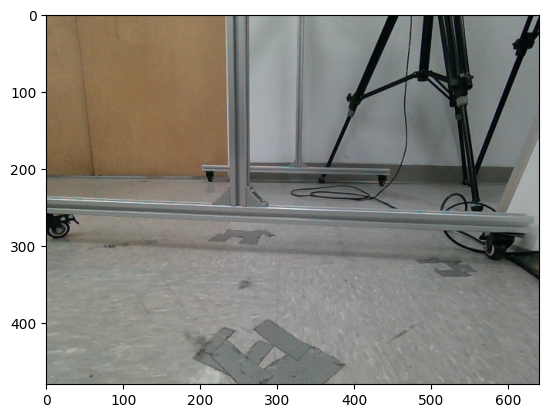

In [7]:
plt.imshow(rgb_camera_bridge.get_image())

In [1]:
import socket
import struct
import numpy as np
import time
import threading
from cyclonedds.domain import DomainParticipant
from cyclonedds.topic import Topic
from cyclonedds.sub import DataReader
from cyclonedds.pub import Publisher, DataWriter
from dataclasses import dataclass
from Go2DDSMsgs import PointCloud, RGBImage, DepthImage, Pose, HighCommand
from scipy.spatial.transform import Rotation as R


def get_last_msg(reader, topic_type):
    """ """
    last_msg = reader.take()

    if last_msg:
        while True:
            a = reader.take()
            if not a:
                break
            else:
                last_msg = a
    if last_msg:
        msg = last_msg[0]
        if type(msg) == topic_type:
            return msg
        else:
            return None

    else:
        return None
    
class Go2DDSServer:
    def __init__(self, robot_name):
        self.robot_name = robot_name
        self.domain = DomainParticipant()
        self.rgb_topic = Topic(self.domain, f'{self.robot_name}_rgb', RGBImage)
        self.depth_topic = Topic(self.domain, f'{self.robot_name}_depth', DepthImage)  
        self.map_topic = Topic(self.domain, f'{self.robot_name}_lio_map', PointCloud)
        self.lidar_odom_topic = Topic(self.domain, f'{self.robot_name}_lio_odom', Pose)
        self.high_cmd_topic = Topic(self.domain, f'{self.robot_name}_high_cmd', HighCommand)
        self.rgb_publisher = Publisher(self.domain)
        self.depth_publisher = Publisher(self.domain)
        self.map_publisher = Publisher(self.domain)
        self.lidar_odom_publisher = Publisher(self.domain)
        self.high_cmd_reader = DataReader(self.domain, self.high_cmd_topic)
        self.rgb_writer = DataWriter(self.rgb_publisher, self.rgb_topic)
        self.depth_writer = DataWriter(self.depth_publisher, self.depth_topic)
        self.map_writer = DataWriter(self.map_publisher, self.map_topic)
        self.lidar_odom_writer = DataWriter(self.lidar_odom_publisher, self.lidar_odom_topic)
        
        
        

    def sendRGB(self, rgb):
        self.rgb_writer.write(RGBImage(data=rgb.reshape(-1).tolist(), width=rgb.shape[1], height=rgb.shape[0], timestamp=''))
    
    def sendDepth(self, depth):
        self.depth_writer.write(DepthImage(data=depth.reshape(-1).tolist(), width=depth.shape[1], height=depth.shape[0], timestamp=''))

    def sendMap(self, pcd):
        map_pcd_mgs = PointCloud(x = pcd[:,0].tolist(), 
                                 y = pcd[:,1].tolist(), 
                                 z = pcd[:,2].tolist(), 
                                 timestamp=''
                                )
        self.map_writer.write(map_pcd_mgs)
    
    def sendLidarOdom(self, lio_T_body):
        q = R.from_matrix(lio_T_body[:3,:3]).as_quat()
        t = lio_T_body[:3,3]
        pose_msg = Pose(quat=q.tolist(), trans=t.tolist(), timestamp='')
        self.lidar_odom_writer.write(pose_msg)

    def getHighCmd(self):
        return get_last_msg(self.high_cmd_reader, HighCommand)    
    

# class Go2DDSClient:
#     def __init__(self, robot_name):
#         self.robot_name = robot_name
#         self.domain = DomainParticipant()
#         self.rgb_topic = Topic(self.domain, f'{self.robot_name}_rgb', RGBImage)
#         self.depth_topic = Topic(self.domain, f'{self.robot_name}_depth', DepthImage)  
#         self.map_topic = Topic(self.domain, f'{self.robot_name}_lio_map', PointCloud)
#         self.lidar_odom_topic = Topic(self.domain, f'{self.robot_name}_lio_odom', Pose)
#         self.high_cmd_topic = Topic(self.domain, f'{self.robot_name}_high_cmd', HighCommand)
#         self.rgb_reader = DataReader(self.domain, self.rgb_topic)
#         self.depth_reader = DataReader(self.domain, self.depth_topic)
#         self.map_reader = DataReader(self.domain, self.map_topic)
#         self.lidar_odom_reader = DataReader(self.domain, self.lidar_odom_topic)
#         self.high_cmd_writer = DataWriter(self.domain, self.high_cmd_topic)

#     def getRGB(self):
#         return get_last_msg(self.rgb_reader, RGBImage)
    
#     def getDepth(self):
#         return get_last_msg(self.depth_reader, DepthImage)
    
#     def getMap(self):
#         return get_last_msg(self.map_reader, PointCloud)
    
#     def getLidarOdom(self):
#         return get_last_msg(self.lidar_odom_reader, Pose)
    
#     def sendHighCmd(self, vx, vy, omega):
#         self.high_cmd_writer.write(HighCommand(vx=vx, vy=vy, omega=omega, timestamp=''))
        

In [1]:
from dds_telemetry import Go2DDSServer, Go2DDSClient

In [2]:
server = Go2DDSServer(robot_name='go2')

In [2]:
client = Go2DDSClient(robot_name='go2')

In [6]:
img = client.getRGB()

In [19]:
client.sendHighCmd(0,0,0)

In [23]:
server.getHighCmd()

HighCommand(vx=0.0, vy=0.0, omega=0.0, timestamp='')

In [3]:
import numpy as np
rgb = np.random.randint(0, 255, (10, 10, 3)).astype(np.uint8)
server.sendRGB(rgb)
